# Exploration of the MA ppln code as a generic pattern-accumulating reservoir

$$\tau_r^i \frac{dr^i}{dt} = -r^i + u^i(t)$$

$$u^i = x_s^i(1 - a_s^i)I_s(t) + x_p^i(1 - a_p^i)I_p(t)$$

$$\tau_a^i \frac{da_s^i}{dt} = -a_s^i + I_s(t)$$

$$\tau_a^i \frac{da_p^i}{dt} = -a_p^i + I_s(t)$$

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
def get_snippets(T_SNP, MIN_GAP, MIN_POWER=0, MAX_POWER=1):
    # get snippets
    nt_snp = int(round(2*FPS))
    t_snp = np.arange(nt_snp)*DT

    snps = []

    # go through all songs
    for ctr, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=int(round(MIN_GAP/DT)))
        
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [
            seg[:nt_snp] for seg in segs
            if (len(seg) >= nt_snp)
            and (np.mean(seg[:nt_snp] > 0) > MIN_POWER)
            and (np.mean(seg[:nt_snp] > 0) < MAX_POWER)
        ]
        
        snps.extend(segs)

    snps = np.array(snps)
    nsnp = len(snps)

    i_ss = [(snp == 1).astype(float) for snp in snps]
    i_ps = [(snp == 2).astype(float) for snp in snps]
    
    return snps, i_ss, i_ps

In [5]:
def smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, dt, adapt='MA'):
    t = np.arange(len(i_s))*dt
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        da_s = (dt/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ss[ct, :] = a_ss[ct-1, :] + da_s
        
        da_p = (dt/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + da_p
        
    return rs, vs, a_ss, a_ps, t

In [6]:
def get_basis(snps_basis, tau_r, tau_a, x_s, x_p, adapt, alpha):
    basis = np.nan*np.zeros((len(tau_r), len(isnps)))
    rs_full = []

    for csnp, snp in enumerate(snps_basis):
        i_s = (snp == 1).astype(float)
        i_p = (snp == 2).astype(float)

        t_snp = np.arange(len(snp))*DT

        rs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT, adapt=adapt)[0]

        basis[:, csnp] = rs[-1, :]
        rs_full.append(rs)
        
    rgr = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    w_readout = rgr.fit(basis.T, np.eye(len(isnps))).coef_.T
    
    return basis, w_readout, rs_full

In [7]:
def make_chirp_song(snp_seq, t_pause):
    seg_pause = np.repeat(0, int(round(t_pause/DT)))
    
    sng_segs = []
    t_chirps = []
    for snp in snp_seq:
        sng_segs.append(seg_pause)
        sng_segs.append(snp)
        t_chirps.append(DT*(len(cc(sng_segs)) - len(snp)/2))
    
    sng_segs.append(seg_pause)
    sng = cc(sng_segs)
    t_sng = np.arange(len(sng))*DT
    
    return sng, t_sng, t_chirps

def make_rand_binary_chirp_song(snp_0, snp_1, nrpt, t_pause):
    ichirps = cc([np.repeat(0, nrpt+1), np.repeat(1, nrpt+1)])[np.random.permutation(2*nrpt+1)].astype(int)
    snp_seq = [[snp_0, snp_1][ichirp] for ichirp in ichirps]
    
    return *make_chirp_song(snp_seq, t_pause), ichirps

In [8]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

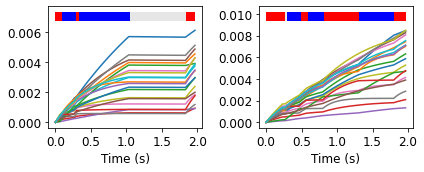

In [9]:
snps, i_ss, i_ps = get_snippets(T_SNP=2, MIN_GAP=3, MIN_POWER=0.5)
isnps = np.random.choice(range(len(snps)), 2, replace=False)
snps_basis = [snps[isnp] for isnp in isnps]

ALPHA = 1e-18
basis, w, rs_full = get_basis(snps_basis, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)
basis_lin, w_lin, rs_full_lin = get_basis(snps_basis, tau_r, tau_a, x_s, x_p, adapt='lin', alpha=ALPHA)

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

for csnp, isnp in enumerate(isnps):
    snp = snps[isnp]
    t_snp = np.arange(len(snp))*DT
    
    axs[csnp].plot(t_snp, rs_full[csnp])
    plot_b(axs[csnp], t_snp, snp, [0, t_snp.max(), 1.1*rs_full[csnp].max(), 1.2*rs_full[csnp].max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[csnp], x_label='Time (s)')

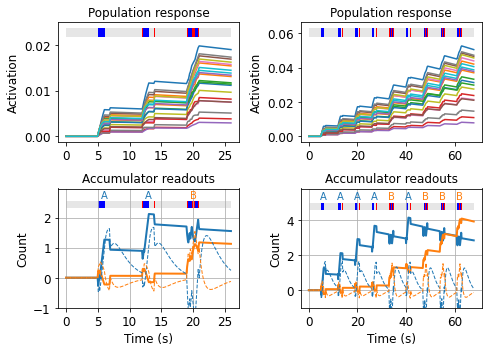

In [10]:
from disp import colors

T_PAUSE = 5
NRPTS = [1, 4]

fig, axs = plt.subplots(2, 2, figsize=(7, 5), tight_layout=True)

for cnrpt, nrpt in enumerate(NRPTS):

    sng, t_sng, t_chirps, ichirps = make_rand_binary_chirp_song(*snps_basis, nrpt, T_PAUSE)

    i_s = (sng == 1)
    i_p = (sng == 2)

    rs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[0]
    rs_lin = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT, adapt='lin')[0]

    axs[0, cnrpt].plot(t_sng, rs)
    plot_b(axs[0, cnrpt], t_sng, sng, [0, t_sng.max(), 1.1*rs.max(), 1.2*rs.max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[0, cnrpt], y_label='Activation', title=f'Population response')

    # MA response
    for w_, color in zip(w.T, colors):
        axs[1, cnrpt].plot(t_sng, rs@w_, lw=2, c=color)
        
    for w_lin_, color in zip(w_lin.T, colors):
        axs[1, cnrpt].plot(t_sng, rs_lin@w_lin_, lw=1, c=color, ls='--')
        
    plot_b(axs[1, cnrpt], t_sng, sng, [0, t_sng.max(), 1.1*(rs@w).max(), 1.2*(rs@w).max()], c=[(.9, .9, .9), 'b', 'r'])
    
    # axs[1, cnrpt].legend(['A', 'B'], loc='center left')
    
    for t_chirp, ichirp in zip(t_chirps, ichirps):
        axs[1, cnrpt].text(t_chirp, 1.25*(rs@w).max(), ['A', 'B'][ichirp], color=colors[ichirp], ha='center')
                           
    axs[1, cnrpt].grid()
    set_plot(axs[1, cnrpt], y_lim=(-1, 1.4*(rs@w).max()), x_label='Time (s)', y_label='Count', title='Accumulator readouts')

In [11]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

In [16]:
NBASIS = 4
NTR = 50
T_SNP = 4
MIN_GAP = 3
MIN_POWER = 0

T_PAUSE = 4
ALPHA = 1e-9

NRPTS = range(1, 11)

acc_mas = np.nan*np.zeros((NBASIS, len(NRPTS)))
acc_lins = np.nan*np.zeros((NBASIS, len(NRPTS)))

snps, i_ss, i_ps = get_snippets(T_SNP=T_SNP, MIN_GAP=MIN_GAP, MIN_POWER=MIN_POWER)

for cbasis in range(NBASIS):
    sys.stdout.write(f'Basis {cbasis}: ')
    
    isnps = np.random.choice(range(len(snps)), 2, replace=False)
    snps_basis = [snps[isnp] for isnp in isnps]
    
    basis, w, rs_full = get_basis(snps_basis, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)
    basis_lin, w_lin, rs_full_lin = get_basis(snps_basis, tau_r, tau_a, x_s, x_p, adapt='lin', alpha=ALPHA)

    for cNRPT, NRPT in enumerate(NRPTS):
        sys.stdout.write(f'NRPT {NRPT} ')

        ncorrect = 0
        ncorrect_lin = 0

        for ctr in range(NTR):
            # sys.stdout.write('.')

            sng, t_sng, t_chirps, ichirps = make_rand_binary_chirp_song(*snps_basis, NRPT, T_PAUSE)

            i_s = (sng == 1)
            i_p = (sng == 2)

            rs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[0]
            rs_lin = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT, adapt='lin')[0]

            # decode
            readout = rs[-1, :]@w
            readout_lin = rs_lin[-1, :]@w_lin

            if readout[0] > readout[1]:
                ncorrect += 1

            if readout_lin[0] > readout_lin[1]:
                ncorrect_lin += 1

        acc_mas[cbasis, cNRPT] = ncorrect/NTR
        acc_lins[cbasis, cNRPT] = ncorrect_lin/NTR

    print()

Basis 0: NRPT 1 NRPT 2 NRPT 3 NRPT 4 NRPT 5 NRPT 6 NRPT 7 NRPT 8 NRPT 9 NRPT 10 
Basis 1: NRPT 1 NRPT 2 NRPT 3 NRPT 4 NRPT 5 NRPT 6 NRPT 7 NRPT 8 NRPT 9 NRPT 10 
Basis 2: NRPT 1 NRPT 2 NRPT 3 NRPT 4 NRPT 5 NRPT 6 NRPT 7 NRPT 8 NRPT 9 NRPT 10 
Basis 3: NRPT 1 NRPT 2 NRPT 3 NRPT 4 NRPT 5 NRPT 6 NRPT 7 NRPT 8 NRPT 9 NRPT 10 


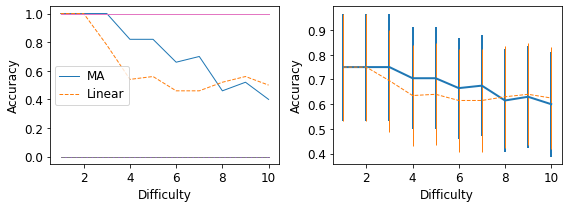

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
for cbasis in range(NBASIS):
    axs[0].plot(NRPTS, acc_mas[cbasis], lw=1)
    axs[0].plot(NRPTS, acc_lins[cbasis], lw=1, ls='--')

axs[0].legend(['MA', 'Linear'])

set_plot(axs[0], x_label='Difficulty', y_label='Accuracy')

axs[1].errorbar(NRPTS, acc_mas.mean(0), yerr=acc_mas.std(0)/np.sqrt(NBASIS), lw=2)
axs[1].errorbar(NRPTS, acc_lins.mean(0), yerr=acc_lins.std(0)/np.sqrt(NBASIS), lw=1, ls='--')

set_plot(axs[1], x_label='Difficulty', y_label='Accuracy')